In [2]:
#import janestreet
import datatable as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc

from tqdm.notebook import tqdm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.core.common.SettingWithCopyWarning)
    
plt.style.use('bmh')
plt.rcParams['figure.figsize'] = [14, 8]  # width, height


# Time Series Cross Validation

> "There are many different ways one can do cross-validation, and **it is the most critical step when building a good machine learning model** which is generalizable when it comes to unseen data."
-- **Approaching (Almost) Any Machine Learning Problem**, by Abhishek Thakur

CV is the **first** step, but very few notebooks are talking about this. Here we look at "purged rolling time series CV" and actually apply it in hyperparameter tuning for a basic estimator. This notebook owes a debt of gratitude to the notebook ["Found the Holy Grail GroupTimeSeriesSplit"](https://www.kaggle.com/jorijnsmit/found-the-holy-grail-grouptimeseriessplit). That notebook is excellent and this solution is an extention of the quoted pending sklearn estimator. I modify that estimator to make it more suitable for the task at hand in this competition. The changes are

- you can specify a **gap** between each train and validation split. This is important because even though the **group** aspect keeps whole days together, we suspect that the anonymized features have some kind of lag or window calculations in them (which would be standard for financial features). By introducing a gap, we mitigate the risk that we leak information from train into validation
- we can specify the size of the train and validation splits in terms of **number of days**. The ability to specify a validation set size is new and the the ability to specify days, as opposed to samples, is new.

The code for `PurgedTimeSeriesSplit` is below. I've hiden it becaused it is really meant to act as an imported class. If you want to see the code and copy for your work, click on the "Code" box.

In [3]:
# TODO: make GitHub GIST
# TODO: add as dataset
# TODO: add logging with verbose

import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
from sklearn.utils.validation import _deprecate_positional_args

# modified code for group gaps; source
# https://github.com/getgaurav2/scikit-learn/blob/d4a3af5cc9da3a76f0266932644b884c99724c57/sklearn/model_selection/_split.py#L2243
class PurgedGroupTimeSeriesSplit(_BaseKFold):
    """Time Series cross-validator variant with non-overlapping groups.
    Allows for a gap in groups to avoid potentially leaking info from
    train into test if the model has windowed or lag features.
    Provides train/test indices to split time series data samples
    that are observed at fixed time intervals according to a
    third-party provided group.
    In each split, test indices must be higher than before, and thus shuffling
    in cross validator is inappropriate.
    This cross-validation object is a variation of :class:`KFold`.
    In the kth split, it returns first k folds as train set and the
    (k+1)th fold as test set.
    The same group will not appear in two different folds (the number of
    distinct groups has to be at least equal to the number of folds).
    Note that unlike standard cross-validation methods, successive
    training sets are supersets of those that come before them.
    Read more in the :ref:`User Guide <cross_validation>`.
    Parameters
    ----------
    n_splits : int, default=5
        Number of splits. Must be at least 2.
    max_train_group_size : int, default=Inf
        Maximum group size for a single training set.
    group_gap : int, default=None
        Gap between train and test
    max_test_group_size : int, default=Inf
        We discard this number of groups from the end of each train split
    """

    @_deprecate_positional_args
    def __init__(self,
                 n_splits=5,
                 *,
                 max_train_group_size=np.inf,
                 max_test_group_size=np.inf,
                 group_gap=None,
                 verbose=False
                 ):
        super().__init__(n_splits, shuffle=False, random_state=None)
        self.max_train_group_size = max_train_group_size
        self.group_gap = group_gap
        self.max_test_group_size = max_test_group_size
        self.verbose = verbose

    def split(self, X, y=None, groups=None):
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
        groups : array-like of shape (n_samples,)
            Group labels for the samples used while splitting the dataset into
            train/test set.
        Yields
        ------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """
        if groups is None:
            raise ValueError(
                "The 'groups' parameter should not be None")
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        group_gap = self.group_gap
        max_test_group_size = self.max_test_group_size
        max_train_group_size = self.max_train_group_size
        n_folds = n_splits + 1
        group_dict = {}
        u, ind = np.unique(groups, return_index=True)
        unique_groups = u[np.argsort(ind)]
        n_samples = _num_samples(X)
        n_groups = _num_samples(unique_groups)
        for idx in np.arange(n_samples):
            if (groups[idx] in group_dict):
                group_dict[groups[idx]].append(idx)
            else:
                group_dict[groups[idx]] = [idx]
        if n_folds > n_groups:
            raise ValueError(
                ("Cannot have number of folds={0} greater than"
                 " the number of groups={1}").format(n_folds,
                                                     n_groups))

        group_test_size = min(n_groups // n_folds, max_test_group_size)
        group_test_starts = range(n_groups - n_splits * group_test_size,
                                  n_groups, group_test_size)
        for group_test_start in group_test_starts:
            train_array = []
            test_array = []

            group_st = max(0, group_test_start - group_gap - max_train_group_size)
            for train_group_idx in unique_groups[group_st:(group_test_start - group_gap)]:
                train_array_tmp = group_dict[train_group_idx]
                
                train_array = np.sort(np.unique(
                                      np.concatenate((train_array,
                                                      train_array_tmp)),
                                      axis=None), axis=None)

            train_end = train_array.size
 
            for test_group_idx in unique_groups[group_test_start:
                                                group_test_start +
                                                group_test_size]:
                test_array_tmp = group_dict[test_group_idx]
                test_array = np.sort(np.unique(
                                              np.concatenate((test_array,
                                                              test_array_tmp)),
                                     axis=None), axis=None)

            test_array  = test_array[group_gap:]
            
            
            if self.verbose > 0:
                    pass
                    
            yield [int(i) for i in train_array], [int(i) for i in test_array]

To show the general idea, we generate some simple grouped data. Imagine we have a dataset of 2,000 samples which below to 20 groups.

In [4]:
n_samples = 2000
n_groups = 20
assert n_samples % n_groups == 0

idx = np.linspace(0, n_samples-1, num=n_samples)
X_train = np.random.random(size=(n_samples, 5))
y_train = np.random.choice([0, 1], n_samples)
groups = np.repeat(np.linspace(0, n_groups-1, num=n_groups), n_samples/n_groups)

In [5]:
from matplotlib.colors import ListedColormap
import numpy as np
import matplotlib.pyplot as plt
    
# this is code slightly modified from the sklearn docs here:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py
def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""
    
    cmap_cv = plt.cm.coolwarm

    jet = plt.cm.get_cmap('jet', 256)
    seq = np.linspace(0, 1, 256)
    _ = np.random.shuffle(seq)   # inplace
    cmap_data = ListedColormap(jet(seq))

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)

    # Plot the data classes and groups at the end
    ax.scatter(range(len(X)), [ii + 1.5] * len(X),
               c=y, marker='_', lw=lw, cmap=plt.cm.Set3)

    ax.scatter(range(len(X)), [ii + 2.5] * len(X),
               c=group, marker='_', lw=lw, cmap=cmap_data)

    # Formatting
    yticklabels = list(range(n_splits)) + ['target', 'day']
    ax.set(yticks=np.arange(n_splits+2) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+2.2, -.2], xlim=[0, len(y)])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    return ax

Let's again imagine we want to do
- a rolling time series split
- where we have a gap of 2 days between train and validation sets
- and we make the maximum size of each train set to be 7 days

Here we specify the number of splits, the maximum number of groups in each train set, and the maximum number of groups in each valdiation set (sklearn has this convention where they call it the "test" set; I preserve that in the variable names, but prefer to call it the validation set).

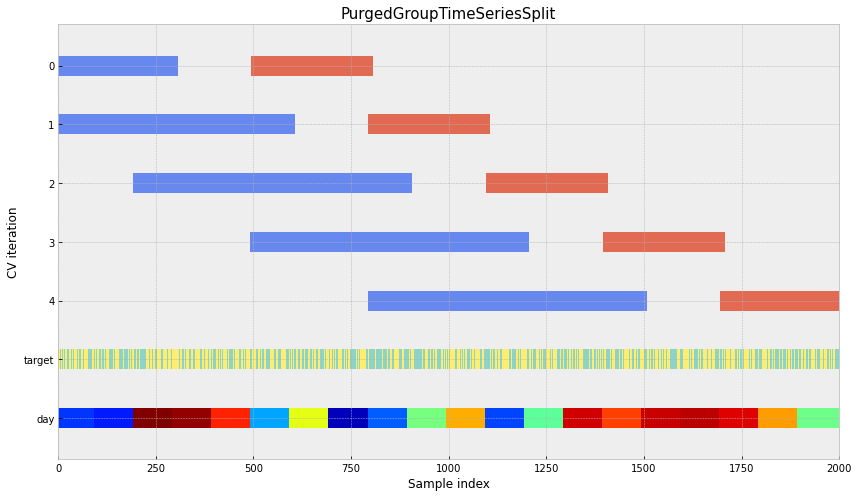

In [6]:
fig, ax = plt.subplots()

cv = PurgedGroupTimeSeriesSplit(
    n_splits=5,
    max_train_group_size=7,
    group_gap=2,
    max_test_group_size=3
)

plot_cv_indices(cv, X_train, y_train, groups, ax, 5, lw=20);

# With the Real Competition Data

In the real competition data, the number of datapoints per day (that is per "group") is not constant as it was in the spoofed data. We need to confirm that the time series split respects that there are different counts of samples in the the days.

We load the data and reduce memory footprint.

In [7]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype.name

        if col_type not in ['object', 'category', 'datetime64[ns, UTC]']:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [8]:
train_data = (
    #dt.fread('../input/jane-street-market-prediction/train.csv')
    dt.fread('../data/001/train.csv')
      .to_pandas()
      .query('weight > 0')
      .pipe(reduce_mem_usage)
)

feature_names = train_data.columns[train_data.columns.str.contains('feature')]

Memory usage of dataframe is 2078.45 MB
Memory usage after optimization is: 540.40 MB
Decreased by 74.0%


Let's imagine that you want to fit on 15 days of data, leave a gap of 5 days between test and validation, and then validate on 5 days of data.

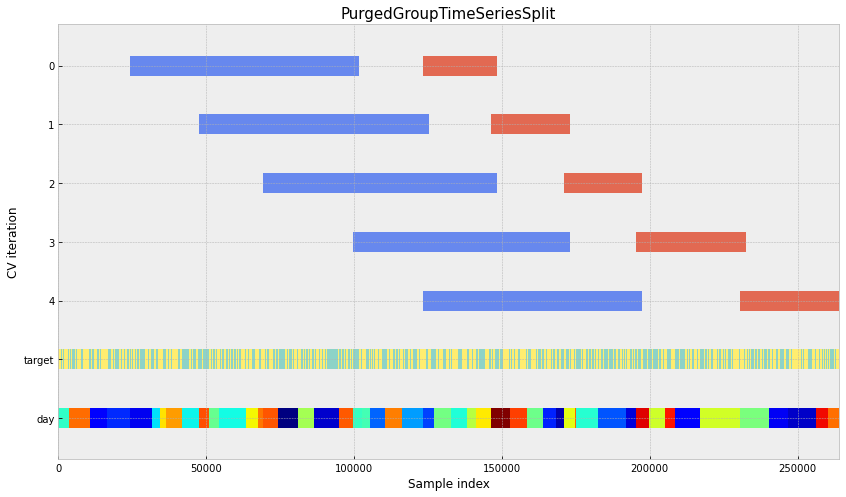

In [9]:
fig, ax = plt.subplots()

cv = PurgedGroupTimeSeriesSplit(
    n_splits=5,
    max_train_group_size=15,
    group_gap=5,
    max_test_group_size=5
)

plot_cv_indices(
    cv,
    train_data.query('date < 50')[
        train_data.columns[train_data.columns.str.contains('feature')]
    ].values,
    (train_data.query('date < 50')['resp'] > 0).astype(int).values,
    train_data.query('date < 50')['date'].values,
    ax,
    5,
    lw=20
);

![Alt Text](https://media.giphy.com/media/5bGYUuT3VEVLa/giphy.gif)

Boom... there you go. Notice that the sizes of the train, gap, and valid sets respect the different number of samples per day. Now you can split the data on **number of days** in the validation set, **number of days** gap between, and **number of days** in the train set. You can see in the "group" bars that the days are different lengths.

# A Worked Example of Hyperparameter Tuning with CV

Now that we can split the data in a very sensible way, we can proceed to build a model. This section builds a very simple (maybe the most simple) pipeline:
- we first mean impute missing values. This dataset has many NaN
- we then scale the data as we are going to use a linear model which requires this
- and lastly, we fit a LogisticRegression

The Logistic Regression has only one hyperparameter: the "C" value which specifies the inverse of the regularization strength. We use the sklearn `Pipeline` and `GridSearchCV` with our `PurgedGroupTimeSeriesSplit` class. Note one benefit of the pipeline approach is that when we impute the means, we are **not** looking ahead into the validation set. 

In [10]:
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from sklearn import set_config
set_config(display='diagram') 

## Set up the Pipeline

In [11]:
# TODO: feature_0 should not be scaled

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
scaler = StandardScaler()

logistic = LogisticRegression(
    max_iter=1000,
    tol=0.1,
    verbose=10,
    penalty='l1',
    solver='liblinear',
    random_state=42
)

pipe = Pipeline(steps=[
    ('imputer', imp_mean),
    ('scaler', scaler),
    ('logistic', logistic)
])

pipe

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('logistic',
                 LogisticRegression(max_iter=1000, penalty='l1',
                                    random_state=42, solver='liblinear',
                                    tol=0.1, verbose=10))])

This ☝ is a nice HTML display of the pipeline. You can click on the objects for more info. In this case, it's a simple pipeline, but this is a really nice feature to explore complex pipelines.

In [12]:
pipe.get_params()

{'memory': None,
 'steps': [('imputer', SimpleImputer()),
  ('scaler', StandardScaler()),
  ('logistic',
   LogisticRegression(max_iter=1000, penalty='l1', random_state=42,
                      solver='liblinear', tol=0.1, verbose=10))],
 'verbose': False,
 'imputer': SimpleImputer(),
 'scaler': StandardScaler(),
 'logistic': LogisticRegression(max_iter=1000, penalty='l1', random_state=42,
                    solver='liblinear', tol=0.1, verbose=10),
 'imputer__add_indicator': False,
 'imputer__copy': True,
 'imputer__fill_value': None,
 'imputer__missing_values': nan,
 'imputer__strategy': 'mean',
 'imputer__verbose': 0,
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'logistic__C': 1.0,
 'logistic__class_weight': None,
 'logistic__dual': False,
 'logistic__fit_intercept': True,
 'logistic__intercept_scaling': 1,
 'logistic__l1_ratio': None,
 'logistic__max_iter': 1000,
 'logistic__multi_class': 'auto',
 'logistic__n_jobs': None,
 'logistic__penalty': '

In [13]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1981287 entries, 1 to 2390489
Columns: 138 entries, date to ts_id
dtypes: float16(135), int16(2), int32(1)
memory usage: 540.4 MB


## Run Cross Validation

We will sequentially try a range of regularization hyperparameters and look at the CV for each. The training data is 500 days; I make 4 splits looking at 125 days in train, skipping 40 days (two months), and validating on the next 40 days.

In [14]:
param_grid = {
 'logistic__C': np.logspace(-3, 1.5, 7),  # lower C is more regularization
}

scoring = {'AUC': 'roc_auc'}

cv = PurgedGroupTimeSeriesSplit(
    n_splits=3,
    max_train_group_size=150,
    group_gap=20,
    max_test_group_size=60
)

search = GridSearchCV(
    pipe,
    param_grid,
    n_jobs=3,
    cv=cv,
    verbose=10,
    scoring=scoring,
    refit=False, # 'AUC',   # <-- do we want to refit on the entire dataset?
    return_train_score=True
)

In [15]:
gc.collect()

2938

In [16]:
%%time

FIT = True

if FIT:
    search.fit(
        train_data[
            train_data.columns[train_data.columns.str.contains('feature')]
        ].values,
        (train_data['resp'] > 0).astype(int).values,
        groups=train_data['date'].values,
    )

Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:   32.1s
[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed:  1.3min
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:  2.2min
[Parallel(n_jobs=3)]: Done  19 out of  21 | elapsed:  3.5min remaining:   22.2s


CPU times: user 1min 18s, sys: 1.17 s, total: 1min 19s
Wall time: 4min 7s


[Parallel(n_jobs=3)]: Done  21 out of  21 | elapsed:  4.0min finished


## Visualize the CV Results

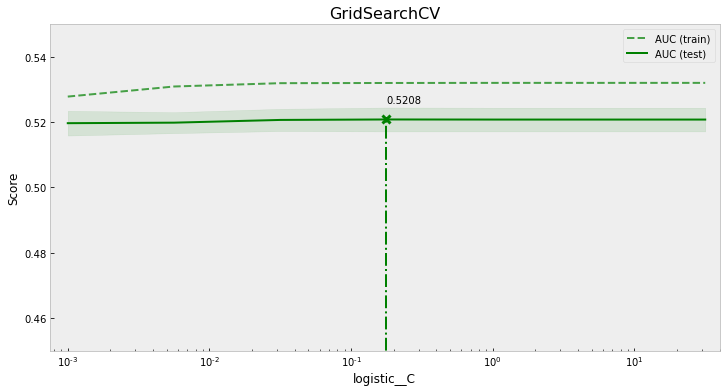

In [17]:
results = search.cv_results_

param = 'param_' + list(param_grid.keys())[0]

plt.figure(figsize=(12, 6))
plt.title("GridSearchCV", fontsize=16)
plt.xlabel(list(param_grid.keys())[0])
plt.ylabel("Score")

ax = plt.gca()
ax.set_xlim(0.00075, 40)
ax.set_ylim(0.45, 0.55)
ax.set_xscale('log')

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results[param].data, dtype=float)

for scorer, color in zip(sorted(scoring), ['g', 'k']):
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
        sample_score_std = results['std_%s_%s' % (sample, scorer)]
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

    best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = results['mean_test_%s' % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.4f" % best_score,
                (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid(False)
plt.show()

It seems that the model is not that sensitive to the regularization parameter. I will err on the side of caution and choose a lower one.

In [18]:
results_idx = np.argmax(results['mean_test_AUC'])
best_param = results[param][results_idx]

print(f'The best setting for C is {best_param}')

The best setting for C is 0.1778279410038923


## Fit the Best Estimator on the Entire Data

In [19]:
logistic = LogisticRegression(
    max_iter=1000,
    C=0.1,
    tol=0.1,
    verbose=10,
    penalty='l1',   # <-- L1 norm to enforce sparsity of coefficients
    solver='liblinear'
)

pipe_lr = Pipeline(steps=[
    ('imputer', imp_mean),
    ('scaler', scaler),
    ('logistic', logistic)
])

In [20]:
gc.collect()

1815

In [21]:
%%time

pipe_lr.fit(
    train_data.query('date > 100')[
        train_data.columns[train_data.columns.str.contains('feature')]
    ].values,
    (train_data.query('date > 100')['resp'] > 0).astype(int).values
)

gc.collect()

[LibLinear]CPU times: user 53.3 s, sys: 3.15 s, total: 56.5 s
Wall time: 57 s


39

# Optuna Hyperparam Search for XGBoost

Unlike Logistic Regression, XGBoost has many parameters. We will use the same CV scheme (`PurgedGroupTimeSeriesSplit`) so that the results are comparable. To search for the best parameters, however, we will use a Baysian optimzer, [**Optuna**](https://github.com/optuna/optuna). 

In [22]:
import xgboost as xgb
import optuna

y_labels = (train_data['resp'] > 0).astype(int).values
X_train = train_data[
    train_data.columns[train_data.columns.str.contains('feature')]
].values
groups = train_data['date'].values

Setting up the Optuna objective function is very straightforward. The new code below is `trial.suggest_...`. This is Optuna code to generate a parameter setting.

In [23]:
cv = PurgedGroupTimeSeriesSplit(
    n_splits=3,
    max_train_group_size=150,
    group_gap=20,
    max_test_group_size=60
)

def objective(trial, cv=cv, cv_fold_func=np.average):

    # Optuna suggest params
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 350, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.10),
        'subsample': trial.suggest_uniform('subsample', 0.50, 0.90),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.50, 0.90),
        'gamma': trial.suggest_int('gamma', 0, 20),
        'missing': -999,
        'tree_method': 'gpu_hist'  
    }
    
    # setup the pieline
    imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
    scaler = StandardScaler()
    clf = xgb.XGBClassifier(**params)

    pipe = Pipeline(steps=[
        ('imputer', imp_mean),
        ('scaler', scaler),
        ('xgb', clf)
    ])


    # fit for all folds and return composite AUC score
    aucs = []
    for i, (train_idx, valid_idx) in enumerate(cv.split(
        X_train,
        y_labels,
        groups=groups)):
        
        train_data = X_train[train_idx, :], y_labels[train_idx]
        valid_data = X_train[valid_idx, :], y_labels[valid_idx]
        
        _ = pipe.fit(X_train[train_idx, :], y_labels[train_idx])
        preds = pipe.predict(X_train[valid_idx, :])
        auc = roc_auc_score(y_labels[valid_idx], preds)
        aucs.append(auc)
    
    print(f'Trial done: AUC values on folds: {aucs}')
    return cv_fold_func(aucs)


In [24]:
gc.collect()

20

In [25]:
np.seterr(over='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [26]:
%%time

FIT_XGB = True

n_trials = 60

if FIT_XGB:
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2021-01-02 06:21:33,993] A new study created in memory with name: no-name-2caea4c4-5349-41b0-ba6e-ca155af4d2f7


[06:21:44] WARNING: ../src/learner.cc:207: No visible GPU is found, setting `gpu_id` to -1


[W 2021-01-02 06:21:44,622] Trial 0 failed because of the following error: XGBoostError('[06:21:44] ../src/gbm/gbtree.cc:459: Check failed: common::AllVisibleGPUs() >= 1 (0 vs. 1) : No visible GPU is found for XGBoost.\nStack trace:\n  [bt] (0) /opt/conda/lib/python3.7/site-packages/xgboost/lib/libxgboost.so(+0x8b514) [0x7fd66b2f3514]\n  [bt] (1) /opt/conda/lib/python3.7/site-packages/xgboost/lib/libxgboost.so(+0x15f7c1) [0x7fd66b3c77c1]\n  [bt] (2) /opt/conda/lib/python3.7/site-packages/xgboost/lib/libxgboost.so(+0x15f9f2) [0x7fd66b3c79f2]\n  [bt] (3) /opt/conda/lib/python3.7/site-packages/xgboost/lib/libxgboost.so(+0x190661) [0x7fd66b3f8661]\n  [bt] (4) /opt/conda/lib/python3.7/site-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x55) [0x7fd66b2e5685]\n  [bt] (5) /opt/conda/lib/python3.7/lib-dynload/../../libffi.so.6(ffi_call_unix64+0x4c) [0x7fd6e1455630]\n  [bt] (6) /opt/conda/lib/python3.7/lib-dynload/../../libffi.so.6(ffi_call+0x22d) [0x7fd6e1454fed]\n  [bt] (7) /opt/co

XGBoostError: [06:21:44] ../src/gbm/gbtree.cc:459: Check failed: common::AllVisibleGPUs() >= 1 (0 vs. 1) : No visible GPU is found for XGBoost.
Stack trace:
  [bt] (0) /opt/conda/lib/python3.7/site-packages/xgboost/lib/libxgboost.so(+0x8b514) [0x7fd66b2f3514]
  [bt] (1) /opt/conda/lib/python3.7/site-packages/xgboost/lib/libxgboost.so(+0x15f7c1) [0x7fd66b3c77c1]
  [bt] (2) /opt/conda/lib/python3.7/site-packages/xgboost/lib/libxgboost.so(+0x15f9f2) [0x7fd66b3c79f2]
  [bt] (3) /opt/conda/lib/python3.7/site-packages/xgboost/lib/libxgboost.so(+0x190661) [0x7fd66b3f8661]
  [bt] (4) /opt/conda/lib/python3.7/site-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x55) [0x7fd66b2e5685]
  [bt] (5) /opt/conda/lib/python3.7/lib-dynload/../../libffi.so.6(ffi_call_unix64+0x4c) [0x7fd6e1455630]
  [bt] (6) /opt/conda/lib/python3.7/lib-dynload/../../libffi.so.6(ffi_call+0x22d) [0x7fd6e1454fed]
  [bt] (7) /opt/conda/lib/python3.7/lib-dynload/_ctypes.cpython-37m-x86_64-linux-gnu.so(_ctypes_callproc+0x2ce) [0x7fd6e06a160e]
  [bt] (8) /opt/conda/lib/python3.7/lib-dynload/_ctypes.cpython-37m-x86_64-linux-gnu.so(+0x13044) [0x7fd6e06a2044]



In [27]:
best_params = trial.params

best_params['missing'] = -999
best_params['tree_method'] = 'gpu_hist' 

NameError: name 'trial' is not defined

In [ ]:
best_params

# Fit the XGBoost Classifier with Optimal Hyperparams

In [ ]:
clf = xgb.XGBClassifier(**best_params)

pipe_xgb = Pipeline(steps=[
    ('imputer', imp_mean),
    ('scaler', scaler),
    ('xgb', clf)
])

pipe_xgb.fit(
    train_data.query('date > 100')[
        train_data.columns[train_data.columns.str.contains('feature')]
    ].values,
    (train_data.query('date > 100')['resp'] > 0).astype(int).values
)

gc.collect()

## Predict on the Test Set

Prediction is a simple loop calling the `predict` method on `pipe`. Note that the mean imputation and scaling is done automatically.

In [ ]:
# which pipeline are we using?

pipe_prod = pipe_xgb

In [ ]:
env = janestreet.make_env()
env_iter = env.iter_test()

for (test_df, pred_df) in tqdm(env_iter):
    if test_df['weight'].item() > 0:
        pred_df.action = pipe_prod.predict(test_df.loc[:, feature_names].values)
    else:
        pred_df.action = 0
    env.predict(pred_df)